# SSRM: Sequential Sample Ratio Mistmatch Test
## Michael Lindon (michael.lindon@optimizely.com)

### What is an SRM?

In almost all online controlled experiments (OCEs) which use random designs, one must specify a traffic allocation to each of the variants in the experiment. If you have never done this, chances are you have been using a default traffic allocation which assigns equal amounts of traffic to all the experiment variants.

A common cause for concern is when the number of visitors assigned to each variant appears somewhat different from what one might expect under the intended traffic allocation. Indeed, this is a signal of an underlying data quality issue or engineering bug in the implementation, which has the potential to invalidate any causal conclusions drawn from the experiment. Loosely speaking, a **Sample Ratio Mistmatch** (SRM) is said to be presented when the observed sample ratios are significantly different from the expected sample ratios. It is widely regarded as a good experimentation practise to check experiments for SRMs. We can formulate this problem statistically to give a precise mathematical definition of an SRM.

### Statistical Model
The simplest example of an A/B test involves two variants, a control and a treatment, and equal traffic allocation to each. To be precise, a new visitor is assigned to the treatment with probability 0.5 upon entering the experiment. Statistically speaking, this assignment is an example of a $\text{Binomial}(1,p)$. The intended traffic allocation corresponds to the *null hypothesis:* $p = 0.5$.  Detection of a sample ratio mismatch can be formulated as a hypothesis test which tests precisely this null hypothesis.

A more general example is provided when there are multiple variants in an experiment to assign visitors to randomly. In this case a user assignment is an example of a $\text{Multinomial}(1,p)$ random variable $x$, which is simply a higher dimensional generalization of the $\text{Binomial}(1,p)$ distribution. If there are $d$ variants in the experiment, then $x$ is a vector of length $d$ containing $d-1$ zeros and $1$ one to indicate the outcome. As an example $x=(0,0,1)$ indicates that the user was assigned to the third variant. Naturally, the parameter $p$ is also a $d$ dimensional vector, with the constraint that the elements are in $[0,1]$ and sum to 1, so that these values correspond to probabilities. The intended traffic allocation to each arm corresponds to a null hypothesis about the parameter $p$. If we expected equal traffic to each variant, then the null hypothesis is $p=[1/3, 1/3, 1/3]$.

$$\begin{align}
H_0: x_1, x_2, \dots \sim \text{Multinomial}(1,p)\hspace{1cm}p=p_0\\
H_1: x_1, x_2, \dots \sim \text{Multinomial}(1,p)\hspace{1cm}p\neq p_0\\
\end{align}$$

There are a number of ways to test this, Bayesian and frequentist, sequential and non sequential. The ssrm package contains a test developed at Optimizely which is sequential and has both Bayesian and frequentist interpretations. 

### SSRM
The wonderful thing about a sequential version of a sample ratio test is that you don't have to wait for the test to finish before it can be executed. The SSRM test detects in real time, from the very beginning of an experiment, if an SRM is present. This allows bugs to be rapidly detected in the early stages of an experiment and corrected, before exposing new users to the variants. For the underlying mathematical details, the reader is referred to our paper. Let's start off and generate some data to work with.

In [52]:
from scipy.stats import multinomial
import numpy as np

# Set the seed of our random number generator for reproducibility. Don't worry about this
np.random.seed(1)

# Our intended allocation probabilities
p_0 = [0.1, 0.5, 0.4]

# The actual allocation probabilities
p = [0.1, 0.45, 0.45]

# Specify number of visitors
N = 10000

# Generate allocations
data = multinomial.rvs(1, p, size=N)

data

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]])

We have just simulated N allocations under probabilities which differ from the intended. The null hypothesis is therefore not correct for this dataset, and we would like to reject the null hypothesis using the ssrm test. 

For an immediate answer, we can import the following function. This gives the Bayesian posterior probability of a sample ratio mismatch.

In [53]:
from ssrm_test.ssrm_test import srm_test

srm_test(data, p_0)

0.9999999999898621

The ssrm_test module is however, much more powerful than just the above functionality. It allows sequential investigations as well as Bayesian and Frequentist analyses. One can track Bayesian and Frequentist metrics of significance in real time, after every datapoint. The `sequential_posteriors` function can be used to get the most raw form of information, and can be converted to Bayes factors with the `bayes_factor` function 

In [54]:
from ssrm_test.ssrm_test import sequential_posteriors, bayes_factor

posteriors = sequential_posteriors(data, p_0)
bayes_factors = [bayes_factor(post) for post in posteriors][1:]

The data returned by `sequential_posteriors` can be used to form both Bayesian and Frequentist Analyses. Let's quickly install matplotlib for visualizing the results, in case your python environment is lacking it.

In [55]:
# Install matplotlib in current python environment
import sys
!{sys.executable} -m pip install matplotlib

You are using pip version 19.0.3, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Frequentist Analysis
To obtain sequential p-values, simply import the `sequential_p_values` function. The probability under the null hypothesis that the sequential p-value falls below $\alpha$ is less than $\alpha$. In otherwords, if you reject the null and declare an SRM to be present when the sequential p-value is less than $\alpha$, then the probability of reporting a **false positive** is at most $\alpha$. 

In [56]:
from ssrm_test.ssrm_test import sequential_p_values
import matplotlib.pyplot as plt

pvals = sequential_p_values(bayes_factors)

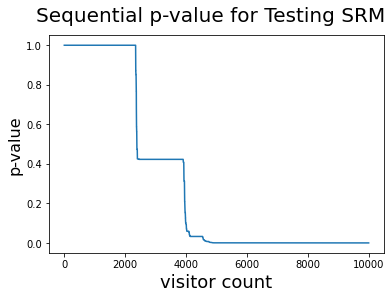

In [57]:
fig = plt.figure()
plt.plot(pvals)
fig.suptitle("Sequential p-value for Testing SRM", fontsize=20)
plt.xlabel("visitor count", fontsize=18)
plt.ylabel("p-value", fontsize=16)
plt.show()

### Bayesian Analysis
To obtain sequential posterior probabilities, simply import the `posterior_probabilities` function.

In [58]:
from ssrm_test.ssrm_test import posterior_probability

posterior_probabilities = [posterior_probability(bf) for bf in bayes_factors]

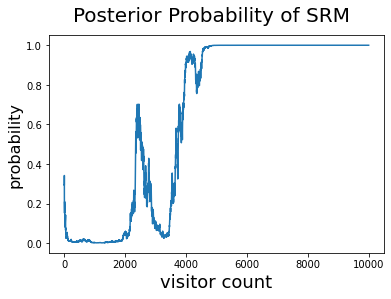

In [59]:
fig = plt.figure()
plt.plot(posterior_probabilities)
fig.suptitle("Posterior Probability of SRM", fontsize=20)
plt.xlabel("visitor count", fontsize=18)
plt.ylabel("probability", fontsize=16)
plt.show()